In [1]:
# Web Analytics Funnel Project

# 1. Goal
# Analyze website behavior and find where users drop off in the funnel.

# 2. Dataset
# We'll load a public ecommerce clickstream dataset.

# 3. Questions
# - What is the overall conversion rate?
# - Which funnel step leaks the most?
# - Do funnels differ by device or channel?


In [2]:
!pip -q install duckdb


In [3]:
import duckdb, os, pandas as pd

os.listdir("/content")  # confirm your CSV name
file_path = "/content/events.csv"  # <-- change to your filename

con = duckdb.connect()
con.execute(f"""
    CREATE TABLE events AS
    SELECT * FROM read_csv_auto('{file_path}')
""")

con.execute("SELECT COUNT(*) AS rows FROM events").df()


,rows
0,885129


In [4]:
con.execute("""
SELECT
  event_type,
  COUNT(*) AS events,
  COUNT(DISTINCT user_session) AS sessions,
  COUNT(DISTINCT user_id) AS users
FROM events
GROUP BY event_type
ORDER BY events DESC;
""").df()


,event_type,events,sessions,users
0,view,793748,488360,406863
1,cart,54035,41270,36952
2,purchase,37346,24344,21304


In [5]:
con.execute("""
WITH session_steps AS (
  SELECT
    user_session,
    MAX(CASE WHEN event_type='view' THEN 1 ELSE 0 END) AS did_view,
    MAX(CASE WHEN event_type='cart' THEN 1 ELSE 0 END) AS did_cart,
    MAX(CASE WHEN event_type='purchase' THEN 1 ELSE 0 END) AS did_purchase
  FROM events
  GROUP BY user_session
)
SELECT
  SUM(did_view) AS sessions_viewed,
  SUM(did_cart) AS sessions_carted,
  SUM(did_purchase) AS sessions_purchased,
  ROUND(SUM(did_cart) * 1.0 / NULLIF(SUM(did_view),0), 4) AS view_to_cart_rate,
  ROUND(SUM(did_purchase) * 1.0 / NULLIF(SUM(did_cart),0), 4) AS cart_to_purchase_rate,
  ROUND(SUM(did_purchase) * 1.0 / NULLIF(SUM(did_view),0), 4) AS view_to_purchase_rate
FROM session_steps;
""").df()


,sessions_viewed,sessions_carted,sessions_purchased,view_to_cart_rate,cart_to_purchase_rate,view_to_purchase_rate
0,488361.0,41271.0,24344.0,0.0845,0.5899,0.0498


In [6]:
con.execute("""
WITH purchases AS (
  SELECT user_session, MIN(event_time) AS purchase_time
  FROM events
  WHERE event_type='purchase'
  GROUP BY user_session
),
views AS (
  SELECT user_session, MIN(event_time) AS first_view_time
  FROM events
  WHERE event_type='view'
  GROUP BY user_session
)
SELECT
  AVG(DATE_DIFF('minute', first_view_time, purchase_time)) AS avg_minutes_to_purchase,
  APPROX_QUANTILE(DATE_DIFF('minute', first_view_time, purchase_time), 0.5) AS median_minutes_to_purchase
FROM purchases p
JOIN views v USING(user_session);
""").df()


,avg_minutes_to_purchase,median_minutes_to_purchase
0,532.415606,4


In [7]:
con.execute("""
SELECT
  product_id,
  COUNT(*) AS purchases,
  ROUND(SUM(price), 2) AS revenue
FROM events
WHERE event_type='purchase'
GROUP BY product_id
ORDER BY revenue DESC
LIMIT 10;
""").df()


,product_id,purchases,revenue
0,1821813,538,213844.24
1,4099645,564,165156.12
2,3791351,423,86414.67
3,4079420,191,85856.41
4,1830099,169,82270.89
5,893196,384,82214.40
6,4078916,196,81445.84
7,4102739,266,78313.06
8,4079565,134,69621.04
9,3791509,149,69511.48


In [8]:
con.execute("""
SELECT
  brand,
  COUNT(*) AS purchases,
  ROUND(SUM(price), 2) AS revenue,
  ROUND(AVG(price), 2) AS avg_price
FROM events
WHERE event_type='purchase'
  AND brand IS NOT NULL
GROUP BY brand
ORDER BY revenue DESC
LIMIT 10;
""").df()


,brand,purchases,revenue,avg_price
0,msi,1788,643492.34,359.90
1,gigabyte,1741,556183.04,319.46
2,palit,1077,484210.58,449.59
3,asus,1261,330147.11,261.81
4,sapphire,917,306192.94,333.91
5,amd,1020,191987.40,188.22
6,canon,1045,137964.79,132.02
7,powercolor,272,98804.38,363.25
8,epson,462,98262.95,212.69
9,pioneer,559,72102.45,128.98


In [9]:
con.execute("""
SELECT
  category_code,
  COUNT(*) AS purchases,
  ROUND(SUM(price), 2) AS revenue
FROM events
WHERE event_type='purchase'
  AND category_code IS NOT NULL
GROUP BY category_code
ORDER BY revenue DESC
LIMIT 10;
""").df()


,category_code,purchases,revenue
0,computers.components.videocards,6888,2604764.80
1,computers.peripherals.printer,2557,364566.80
2,computers.components.cpu,1213,219168.98
3,electronics.telephone,4119,150915.69
4,stationery.cartrige,2739,103595.99
5,computers.components.motherboard,1266,102871.16
6,electronics.audio.acoustic,848,84724.80
7,auto.accessories.player,685,81558.66
8,computers.notebook,1297,63604.79
9,electronics.video.tv,389,57987.91


In [10]:
con.execute("""
WITH product_views AS (
  SELECT product_id, COUNT(*) AS views
  FROM events
  WHERE event_type='view'
  GROUP BY product_id
),
product_purchases AS (
  SELECT product_id, COUNT(*) AS purchases
  FROM events
  WHERE event_type='purchase'
  GROUP BY product_id
)
SELECT
  v.product_id,
  views,
  COALESCE(purchases,0) AS purchases,
  ROUND(COALESCE(purchases,0) * 1.0 / NULLIF(views,0), 4) AS view_to_purchase_rate
FROM product_views v
LEFT JOIN product_purchases p USING(product_id)
WHERE views >= 100  -- filter to meaningful volume
ORDER BY view_to_purchase_rate ASC
LIMIT 20;
""").df()


,product_id,views,purchases,view_to_purchase_rate
0,669304,252,0,0.0
1,3828758,372,0,0.0
2,799658,223,0,0.0
3,454553,129,0,0.0
4,564677,189,0,0.0
5,953162,161,0,0.0
6,4100924,242,0,0.0
7,215459,116,0,0.0
8,1660969,140,0,0.0
9,3658397,136,0,0.0


In [11]:
con.execute("""
WITH purchases AS (
  SELECT
    user_id,
    MAX(DATE(event_time)) AS last_purchase_date,
    COUNT(*) AS purchase_count,
    SUM(price) AS total_spend
  FROM events
  WHERE event_type='purchase'
  GROUP BY user_id
),
scored AS (
  SELECT
    user_id,
    DATE_DIFF('day', last_purchase_date, (SELECT MAX(DATE(event_time)) FROM events)) AS recency_days,
    purchase_count AS frequency,
    total_spend AS monetary
  FROM purchases
)
SELECT *
FROM scored
ORDER BY monetary DESC
LIMIT 10;
""").df()


,user_id,recency_days,frequency,monetary
0,1515915625601579158,21,56,12080.83
1,1515915625530137422,116,18,9418.62
2,1515915625547240612,37,16,8639.69
3,1515915625600723220,24,19,8447.61
4,1515915625596222123,27,24,8047.99
5,1515915625591659523,26,49,6629.87
6,1515915625596534847,22,45,6286.98
7,1515915625596298594,35,6,5931.08
8,1515915625602773715,20,19,5705.96
9,1515915625519495480,148,5,5489.08


<Axes: title={'center': 'Funnel Counts'}>

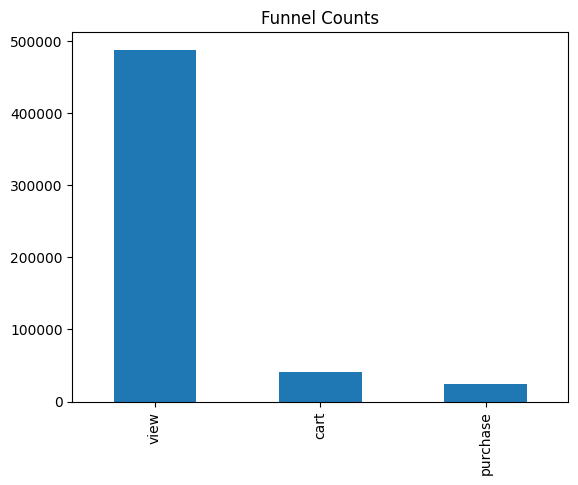

In [12]:
funnel = con.execute("""
WITH session_steps AS (
  SELECT
    user_session,
    MAX(CASE WHEN event_type='view' THEN 1 ELSE 0 END) AS did_view,
    MAX(CASE WHEN event_type='cart' THEN 1 ELSE 0 END) AS did_cart,
    MAX(CASE WHEN event_type='purchase' THEN 1 ELSE 0 END) AS did_purchase
  FROM events
  GROUP BY user_session
)
SELECT
  SUM(did_view) AS view,
  SUM(did_cart) AS cart,
  SUM(did_purchase) AS purchase
FROM session_steps;
""").df()

funnel.T.plot(kind="bar", legend=False, title="Funnel Counts")


In [13]:
segments = con.execute("""
WITH purchases AS (
  SELECT
    user_id,
    MAX(DATE(event_time)) AS last_purchase_date,
    COUNT(*) AS frequency,
    SUM(price) AS monetary
  FROM events
  WHERE event_type='purchase'
  GROUP BY user_id
),
scored AS (
  SELECT
    user_id,
    DATE_DIFF('day', last_purchase_date, (SELECT MAX(DATE(event_time)) FROM events)) AS recency_days,
    frequency,
    monetary
  FROM purchases
)
SELECT
  CASE
    WHEN recency_days <= 30 AND frequency >= 5 THEN 'VIP / Loyal'
    WHEN recency_days <= 30 AND frequency < 5 THEN 'New / Promising'
    WHEN recency_days > 30 THEN 'Churn Risk'
  END AS segment,
  COUNT(*) AS users,
  ROUND(AVG(frequency),2) AS avg_orders,
  ROUND(AVG(monetary),2) AS avg_spend
FROM scored
GROUP BY segment
ORDER BY users DESC;
""").df()

segments


,segment,users,avg_orders,avg_spend
0,Churn Risk,16557,1.73,213.53
1,New / Promising,4510,1.51,275.40
2,VIP / Loyal,237,8.27,1468.33


In [14]:
con.execute("""
WITH session_steps AS (
  SELECT
    user_session,
    MAX(CASE WHEN event_type='cart' THEN 1 ELSE 0 END) AS did_cart,
    MAX(CASE WHEN event_type='purchase' THEN 1 ELSE 0 END) AS did_purchase
  FROM events
  GROUP BY user_session
)
SELECT
  SUM(did_cart) AS cart_sessions,
  SUM(CASE WHEN did_cart=1 AND did_purchase=0 THEN 1 ELSE 0 END) AS abandoned_carts,
  ROUND(SUM(CASE WHEN did_cart=1 AND did_purchase=0 THEN 1 ELSE 0 END) * 1.0 / NULLIF(SUM(did_cart),0),4) AS cart_abandon_rate
FROM session_steps;
""").df()


,cart_sessions,abandoned_carts,cart_abandon_rate
0,41271.0,20509.0,0.4969


<Axes: title={'center': 'Users by Segment'}, xlabel='segment'>

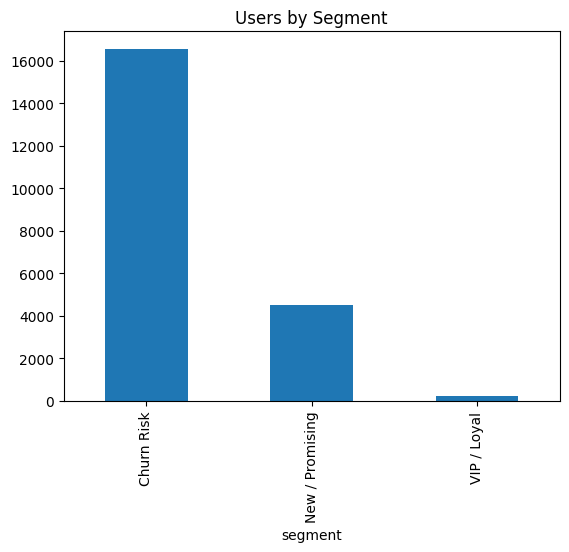

In [15]:
segments_df = segments  # the dataframe you already printed

segments_df.set_index("segment")["users"].plot(kind="bar", title="Users by Segment")
